<a href="https://colab.research.google.com/github/teoad95/Deep-learning-Cryptocurrency-price-prediction/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Problem</h1>
<p>
In the recent years, cryptocurrencies have been very popular. That's because their values change over time in a great extend. In this notebook we will try to solve this problem by using both historical data and social media activity in order to 
</p>
<ol>
  <li>Predict future prices, <b>Regression problem</b> </li>
  <li>Predict whether the price will increase or decrease, <b>Classification problem</b></li>
</ol>


<h2>Pre-required libraries</h2>

<h1>Section 1<h1>
<h2> Data preprocessing </h2>
<p> The crypto with which we worked is Bitcoin. Bitcoin was created in January 2009.
Bitcoin offers the promise of lower transaction fees than traditional online payment mechanisms and, unlike government-issued currencies, it is operated by a decentralized authority.</p>
<p>There are many sources from where historical data can get found. For Bitcoin's historical data, we started by using the yahoo's finance platform however, because of the Coinmarket provides also the dailly market cap, we collected them from there.</p>
<p>Regarding, social media activity data, their availabillity is limited accross the internet, at least for free. Cryptocompare and Lunarcrash apis used. Unfortunatelly, we didn't achieve to get data for the whole life of the coin by only for close to 3 years.</p>

In [2]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os

<h3>Load data and plots</h3>



TODO Load data

In [3]:
btc_url = 'https://raw.githubusercontent.com/teoad95/Deep-learning-Cryptocurrency-price-prediction/main/Datasets/Market%20info/BTC-USD.csv'
eth_url = 'https://raw.githubusercontent.com/teoad95/Deep-learning-Cryptocurrency-price-prediction/main/Datasets/Market%20info/ETH-USD.csv'

In [4]:
coin_market_info = pd.read_csv(btc_url)

In [5]:
# replace na cells, convert Date column to DateTime
coin_market_info['Date'] = pd.to_datetime(coin_market_info['Date'])
coin_market_info.fillna(method='ffill',inplace=True) 

<p>Dataset contains 7 columns
<ul>
<li>Date</li>
<li>Open, the open market price</li>
<li>High, the highest market price for this date</li>
<li>Low, the lowest market price for this date</li>
<li>Close, the close market price for this date</li>
<li>Adj Close, the close market price for this date after adjustments</li>
<li>Volume, physical number of cryptos traded</li>
</ul></p>
<p> Also, extra features added manually
<ul>
  <li>day_diff, the difference of Close with Open, divided by the Open price</li>
  <li>volatility, the difference of High with Low, divided by the Open price</li>
</ul>
</p>

In [6]:
extra_fields = {'day_diff': lambda x: (x['Close']-x['Open'])/x['Open'],
          'volatility': lambda x: (x['High']- x['Low'])/(x['Open'])}
coin_market_info = coin_market_info.assign(**extra_fields)

<h4> Close price and Volume over time</h4>


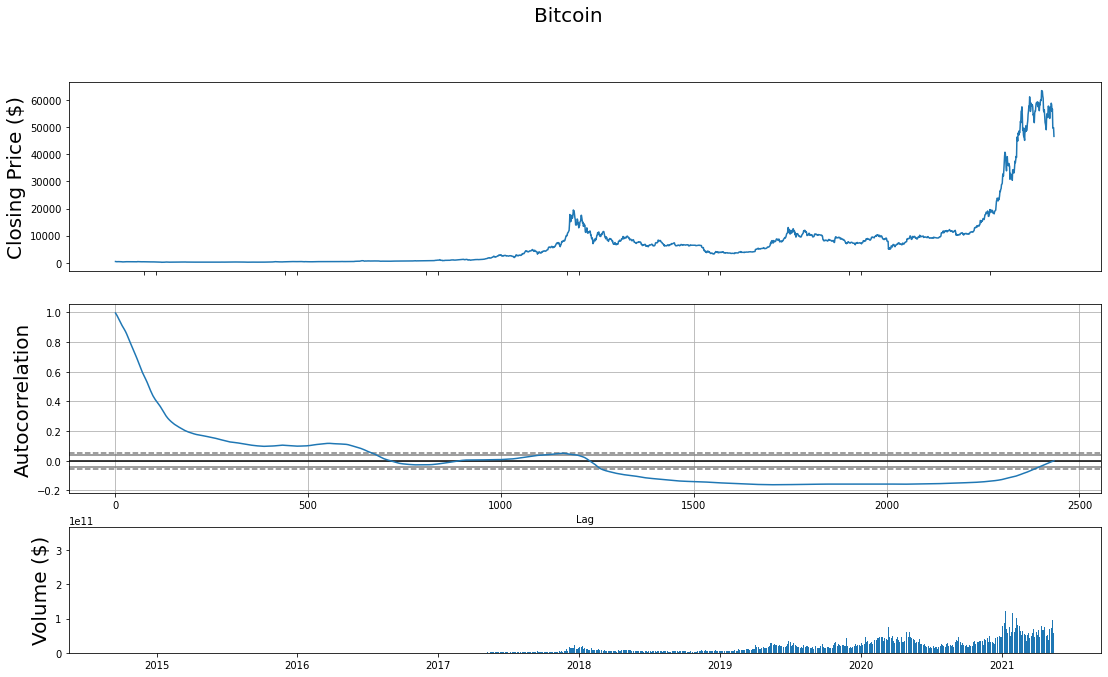

In [7]:
fig, (ax1, ax3, ax2) = plt.subplots(3,1, gridspec_kw = {'height_ratios':[3, 3, 2]})
ax1.set_ylabel('Closing Price ($)',fontsize=20)
ax2.set_ylabel('Volume ($)',fontsize=20)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2021) for j in [1,12]])
ax1.set_xticklabels('')
ax3.set_ylabel('Autocorrelation' ,fontsize=20)
ax1.plot(coin_market_info['Date'],coin_market_info['Open'])
ax2.bar(coin_market_info['Date'], coin_market_info['Volume'].values)
autocorrelation_plot(coin_market_info['Close'], ax=ax3)
fig.set_size_inches(18.5, 10.5)
fig.suptitle('Bitcoin', fontsize = 20)
plt.show()

<p> Regarding the correlation diagram, when the line is out of the grey bounds, then with 95% confidence level there is no significant correlation of Close value with Time, in the given fraction.</p>
<p>If so, it means that these values are randomly distributed or they depend on several other factors.</p>
<p> We will try by including more features apart from Close to increase the model's performance because seems that the variation of the variable we try to predict follows a random distribution.</p>

<h3>Split data to training, testing and validation</h3>
<p> 75% of the dataset will be used to train the model.</p>
<p> The rest 25% percent will get divided in equal portition for the test and the validation.</p>

In [8]:
def split_dataset_to_train_and_validation(ds_to_split, percentage_of_train_from_all, percentage_of_validation_from_training):
    split_date = ds_to_split.iloc[round(ds_to_split.shape[0] * percentage_of_train_from_all)]['Date']
    training_set, val_test_set = ds_to_split[ds_to_split['Date'] < split_date], \
                            ds_to_split[ds_to_split['Date'] >= split_date]


    split_date_val = val_test_set.iloc[round(val_test_set.shape[0] * percentage_of_validation_from_training)]['Date']

    val_set, test_set = val_test_set[val_test_set['Date'] < split_date_val], \
                        val_test_set[val_test_set['Date'] >= split_date_val]

    return training_set, test_set, val_set, split_date, split_date_val

In [9]:
percent_train_set = 0.75
percent_val_set = 0.5

training_set, test_set, val_set, split_date, split_date_val = split_dataset_to_train_and_validation(coin_market_info, percent_train_set, percent_val_set)

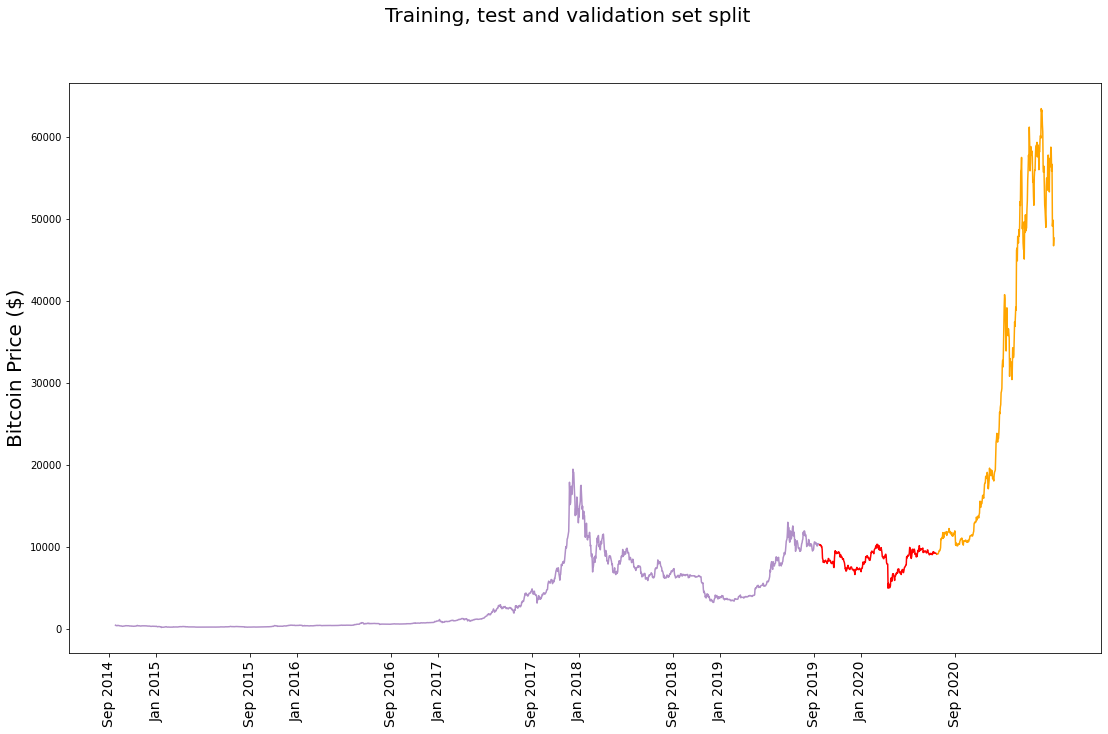

In [10]:
fig, (ax2) = plt.subplots(1,1)
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2021) for j in [1,9]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2021) for j in [1,9]])
ax2.plot(coin_market_info[coin_market_info['Date'] < split_date]['Date'],
         coin_market_info[coin_market_info['Date'] < split_date]['Close'], 
         color='#B08FC7')
ax2.plot(coin_market_info.loc[(coin_market_info['Date'] >= split_date) & (coin_market_info['Date'] < split_date_val)]['Date'],
         coin_market_info.loc[(coin_market_info['Date'] >= split_date) & (coin_market_info['Date'] < split_date_val)]['Close'], color='red')
ax2.plot(coin_market_info.loc[coin_market_info['Date'] >= split_date_val]['Date'],
         coin_market_info.loc[coin_market_info['Date'] >= split_date_val]['Close'], color='orange')
ax2.set_ylabel('Bitcoin Price ($)',fontsize=20)
fig.set_size_inches(18.5, 10.5)
plt.xticks(fontsize=14, rotation=90)
fig.suptitle('Training, test and validation set split', fontsize = 20)
plt.show()


<h3>Data normalization</h3>
<p>Data normalized on windows of X days. That's because even in the range of 0,1 the first years data wouldn't contribute the same as the data of the latests</p>


In [21]:
window_len = 10

In [22]:
def normalize_data_in_windows(window_size, data):
  training_inputs = []
  for i in range(len(data) - window_len):
    temp_set = data[i:(i + window_len)].copy()
    temp_set = temp_set.drop(['Date'], axis=1)
    temp_set = temp_set.drop(['Open'], axis=1)
    temp_set = temp_set.drop(['High'], axis=1)
    temp_set = temp_set.drop(['Low'], axis=1)
    temp_set = temp_set.drop(['Adj Close'], axis=1)

    for col in ['Close', 'Volume']:
        # inputs normalization
        temp_set[:][col] = temp_set[col] / temp_set[col].iloc[0] - 1

    training_inputs.append(temp_set)
  # outputs normalization
  training_outputs = (data['Close'][window_len:].values / data['Close'][:-window_len].values) - 1

  # convert to numpy
  training_inputs = [np.array(training_input) for training_input in training_inputs]
  training_inputs = np.array(training_inputs)
  return training_inputs, training_outputs

In [ ]:
LSTM_training_inputs, LSTM_training_outputs = normalize_data_in_windows(window_len, training_set)
LSTM_test_inputs, LSTM_test_outputs = normalize_data_in_windows(window_len, test_set)
LSTM_val_inputs, LSTM_val_outputs = normalize_data_in_windows(window_len, val_set)

<h1>Section 2<h1>
<h2> Regression with historical data </h2>

<p> For the neural network, the tensorflow library used. </p>
<h3>Define LSTM model</h3>
<p> On our first attempt a simple LSTM architecture utilized with a single dense output layer. More specifically, the model architecture is an LSTM layer followed by a dropout, followed by a single dense and passed through an activation function before the value return from the network.</p>
<p>A method has been made for the model creation. Number of neurons, activation function, dropout percentage, loss function and optimizer are variable values. For the presented case, we used 20 neurons, with linear activation function, 25% dropout percentage, Mean Absolute Error loss function and adam optimizer.</p>

In [52]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf


def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [45]:
np.random.seed(202)
epochs = 20
batch_size = 64
neurons = 20

In [ ]:
bitcoin_model = build_model(LSTM_training_inputs, output_size=1, neurons=neurons)
hist = bitcoin_model.fit(LSTM_training_inputs, LSTM_training_outputs, validation_data=(LSTM_val_inputs, LSTM_val_outputs),
                        epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True)

<h3>Plot loss and validation set loss</h3>

In [46]:
def plot_loss_and_val_loss(hist):
  fig, ax1 = plt.subplots(1, 1)
  ax1.plot(hist.epoch, hist.history['loss'], color='b', label='Loss')
  ax1.plot(hist.epoch, hist.history['val_loss'], color='orange', label='Val_loss')
  ax1.set_xticks(range(0, len(hist.epoch)))
  ax1.set_title('Training Error')
  ax1.set_ylabel('Mean Absolute Error (MAE)', fontsize=12)
  ax1.set_xlabel('#Epoch', fontsize=12)
  fig.set_size_inches(18.5, 10.5)
  plt.legend()
  plt.show()

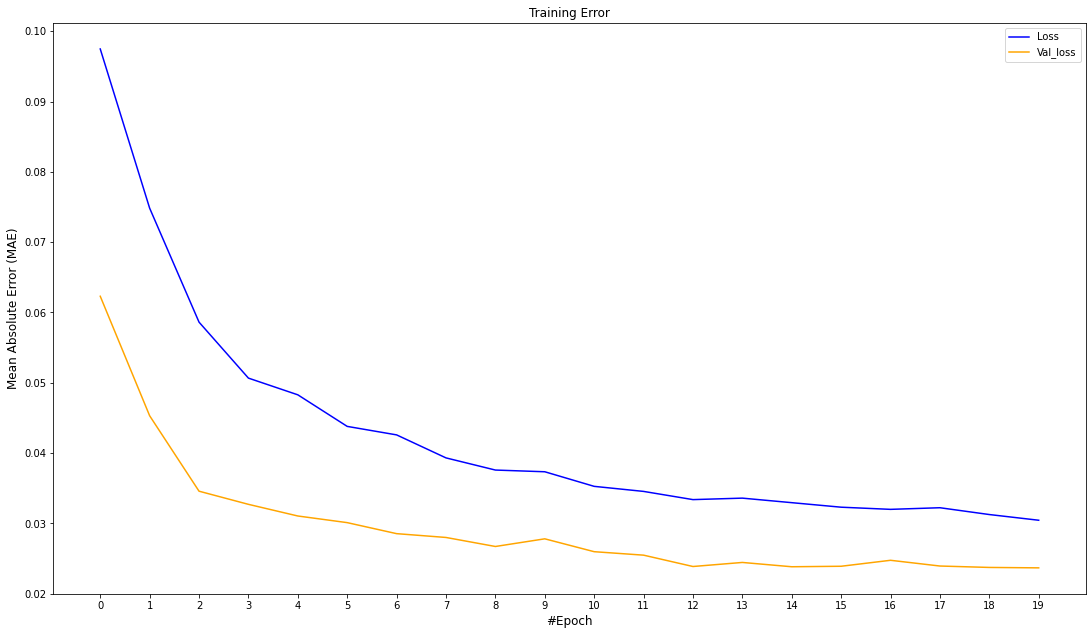

In [ ]:
plot_loss_and_val_loss(hist)

<p>We can observe that both losse's curves decrease together so seems like the model goes quite well in terms of generalization.</p>

<h3>Plot side by side prediction with actuals</h3>

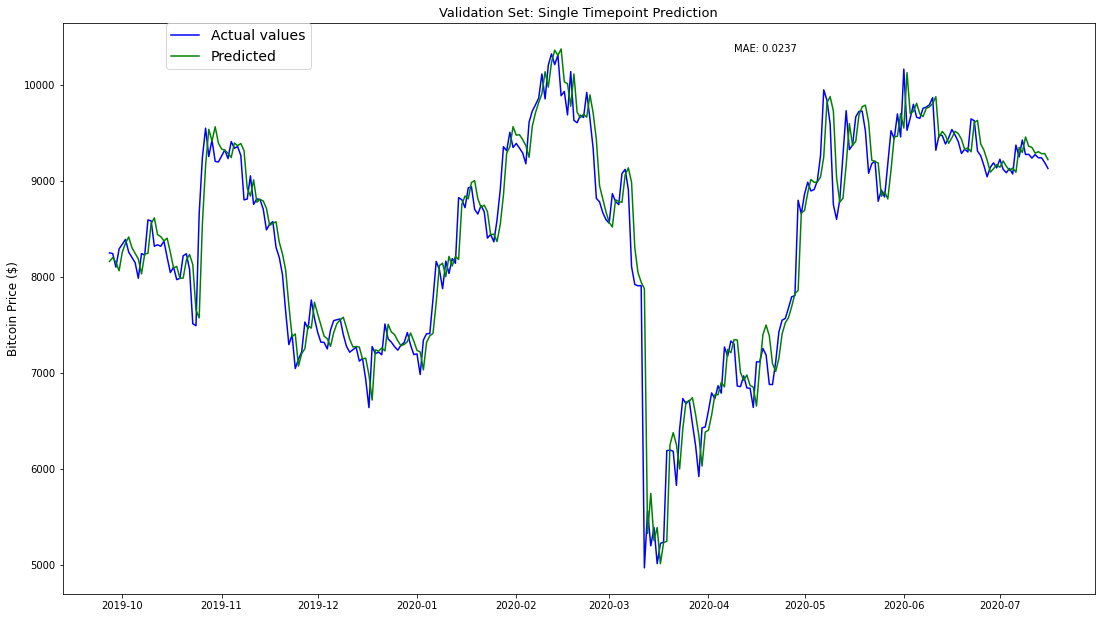

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,10))
ax1.plot(pd.to_datetime(coin_market_info.loc[(coin_market_info['Date'] >= split_date) & (coin_market_info['Date'] < split_date_val)]['Date'][window_len:]),
         val_set['Close'][window_len:], label='Actual values', color='b')
ax1.plot(pd.to_datetime(coin_market_info.loc[(coin_market_info['Date'] >= split_date) & (coin_market_info['Date'] < split_date_val)]['Date'][window_len:]),
         ((np.transpose(bitcoin_model.predict(LSTM_val_inputs)) + 1) * val_set['Close'].values[:-window_len])[0],
         label='Predicted', color='g')
ax1.legend(loc=2, bbox_to_anchor=(0.1, 1), borderaxespad=0., prop={'size': 14})
ax1.annotate('MAE: %.4f' % np.mean(np.abs((np.transpose(bitcoin_model.predict(LSTM_val_inputs)) + 1) - \
                                          (val_set['Close'].values[window_len:]) / (val_set['Close'].values[:-window_len]))),
             xy=(0.65, 0.95), xycoords='axes fraction',
             xytext=(0.65, 0.95), textcoords='axes fraction')
ax1.set_title('Validation Set: Single Timepoint Prediction', fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)', fontsize=12)
fig.set_size_inches(18.5, 10.5)
plt.show()

<p>From the previous diagram we can easily infer that the model learns to predict as close value equal to previous day's close value and that's because the differ between these two values is not as high in order to cause big increase of the loss function. For this reason the two diagrams are almost identical, with the prediction shifted to the right.</p>
<p>For this reason and in order to make the network's prediction harder, we increased complexity to 5 days prediction. By doing that we focus more to price increase/decrease prediction rather than the actual price.</p>
<p>In order this to be done, we have to configure the output sets</p>

In [47]:
pred_range = 5

LSTM_ranged_training_outputs = []
for i in range(window_len, len(training_set['Close']) - pred_range):
    LSTM_ranged_training_outputs.append((training_set['Close'][i:i+pred_range].values/training_set['Close'][training_set.index[0]+i-window_len]) - 1)

LSTM_ranged_training_outputs = np.array(LSTM_ranged_training_outputs)


LSTM_ranged_val_outputs = []
for i in range(window_len, len(val_set['Close']) - pred_range):
    LSTM_ranged_val_outputs.append((val_set['Close'][i:i+pred_range].values/val_set['Close'][val_set.index[0]+i-window_len]) - 1)

LSTM_ranged_val_outputs = np.array(LSTM_ranged_val_outputs)

KeyError: ignored

<p> Create new model with different output size, as we now expect 5 outputs instead of 1. </p>

In [ ]:
ranged_bitcoin_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons=neurons)

In [ ]:
hist = ranged_bitcoin_model.fit(LSTM_training_inputs[:-pred_range], LSTM_ranged_training_outputs, validation_data=(LSTM_val_inputs[:-pred_range], LSTM_ranged_val_outputs), epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True, workers=8)

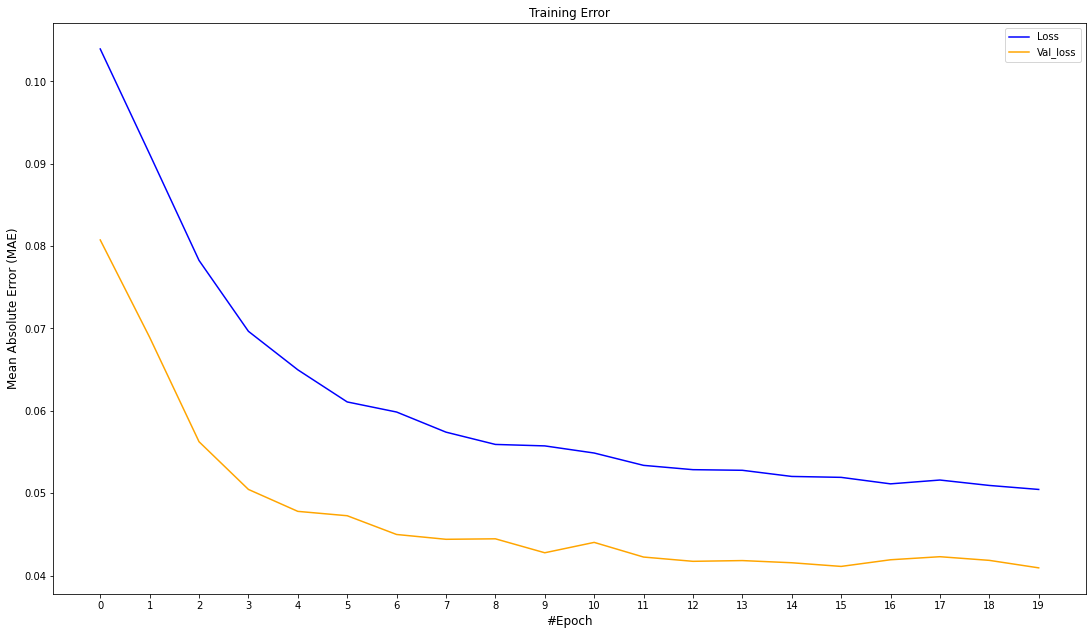

In [ ]:
plot_loss_and_val_loss(hist)

<p>As we can see, neither the loss nor the validation loss dicrease. This means that the model is still underfit. For this reason we will increase the number of epochs and we will try again</p>

In [ ]:
epochs = 100
hist = ranged_bitcoin_model.fit(LSTM_training_inputs[:-pred_range], LSTM_ranged_training_outputs, validation_data=(LSTM_val_inputs[:-pred_range], LSTM_ranged_val_outputs), epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True, workers=8)

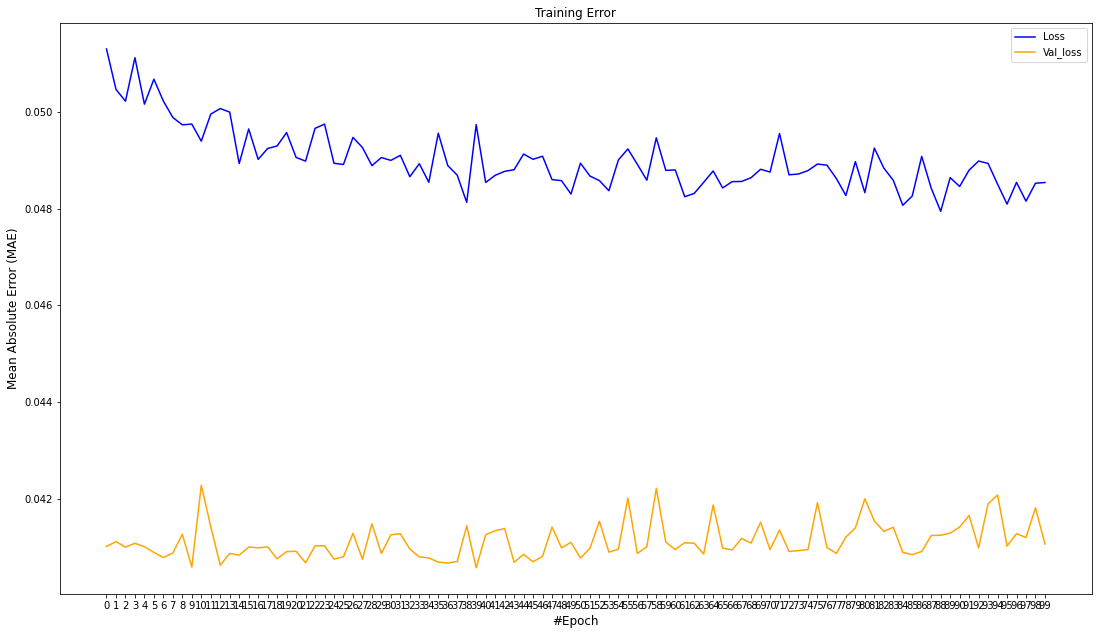

In [ ]:
plot_loss_and_val_loss(hist)

<p>As we can still see, the model continues to not performs as expected. Validation loss increases while the loss decreases. This means that the model tends to overfit. We will try again by increasing the number of neurons.</p>

In [ ]:
neurons = 100
ranged_bitcoin_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons=neurons)

In [ ]:
hist = ranged_bitcoin_model.fit(LSTM_training_inputs[:-pred_range], LSTM_ranged_training_outputs, validation_data=(LSTM_val_inputs[:-pred_range], LSTM_ranged_val_outputs), epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True, workers=8)

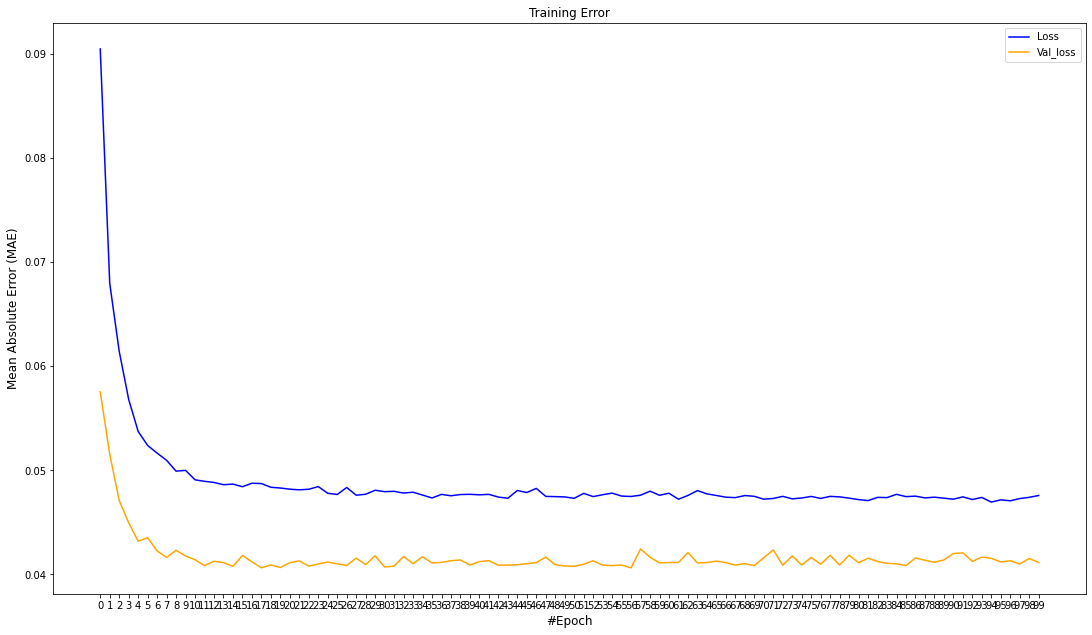

In [ ]:
plot_loss_and_val_loss(hist)

<p>The results seems to be quite better than before. Both losses decreases together. </p>

<h3>Plot side by side prediction with actuals</h3>

In [53]:
def plot_actual_against_ranged_prediction(ds, m, p_range, w_length, lstm_val_input, val_inp, s_date, s_date_val, predicted_column, figure_title = ''):
  #Get predictions which are scaled
  scaled_pred_prices = (m.predict(lstm_val_input)[:-p_range][::p_range])

  #Apply inverse tranformation to get unscaled predictions
  pred_prices = (scaled_pred_prices + 1) *\
                val_inp[predicted_column].values[:-(w_length + p_range)][::p_range].reshape(int(np.ceil((len(lstm_val_input) -
                                                                                              p_range)/float(p_range))), 1)

  #Reshape scaled predictions in order to use them in computing MAE of normalized data
  scaled_pred_prices = ((m.predict(lstm_val_input)[:-p_range][::p_range]).copy()).reshape(-1)
  pred_colors = ["#FF69B4", "#5D6D7E", "#F4D03F", "#A569BD", "#45B39D"]
  fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
  ax1.plot(pd.to_datetime(ds.loc[(ds['Date'] >= s_date) & (ds['Date'] < s_date_val)]['Date'][w_length:]),
         val_inp[predicted_column][w_length:], label='Actual values', color='b')

  for i, pred in enumerate(pred_prices):

      if i < p_range: #Print label=predicted for the first time

          ax1.plot(pd.to_datetime(ds.loc[(ds['Date'] >= s_date) & (ds['Date'] < s_date_val)]['Date'][w_length:])[(i * p_range):((i * p_range) + p_range)],
                  pred, color=pred_colors[i % p_range], label='Predicted')

      else: #Dont print label=predicted again

          ax1.plot(pd.to_datetime(ds.loc[(ds['Date'] >= s_date) & (ds['Date'] < s_date_val)]['Date'][w_length:])[
                  (i * p_range):((i * p_range) + p_range)],
                  pred, color=pred_colors[i % p_range])

  ax1.set_title('Validation Set: 5 Timepoint Predictions', fontsize=13)
  ax1.set_ylabel('Bitcoin Price ($)', fontsize=12)
  ax1.legend(bbox_to_anchor=(0.13, 1), loc=2, borderaxespad=0., prop={'size': 12})
  ax1.legend(loc=2, bbox_to_anchor=(0.1, 1), borderaxespad=0., prop={'size': 14})
  fig.suptitle(figure_title, fontsize=20)
  fig.set_size_inches(18.5, 10.5)
  plt.show()

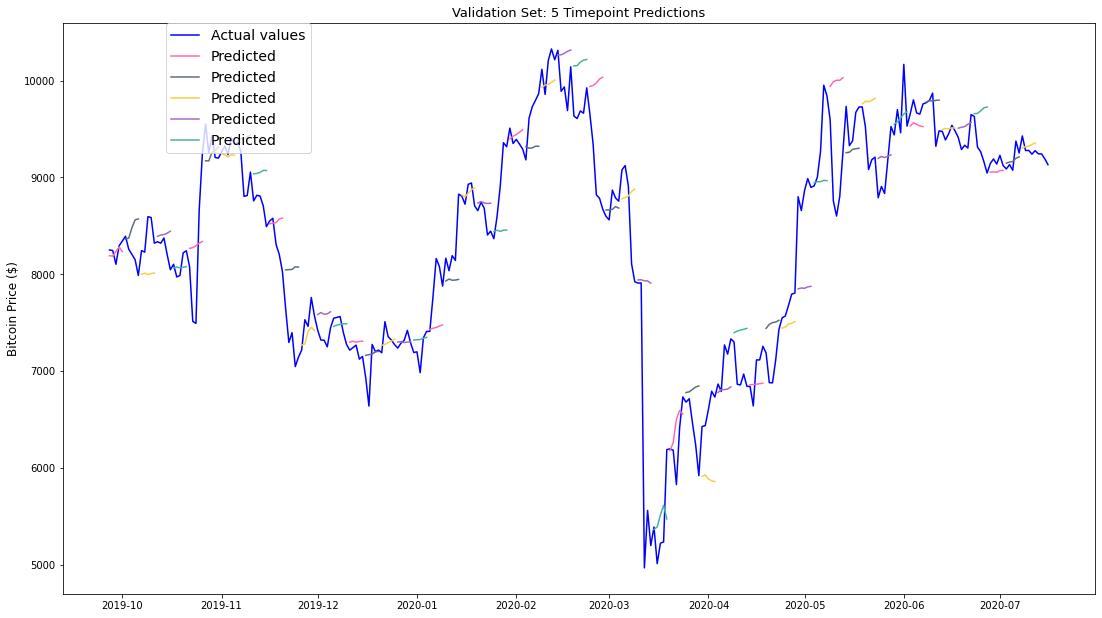

In [ ]:
plot_actual_against_ranged_prediction(coin_market_info, ranged_bitcoin_model, pred_range, window_len, LSTM_val_inputs, val_set, split_date, split_date_val, 'Close')

<p> We can easily understand now, using the diagram that even if the model seems to start to perform well on the problem, the predictions are not as accured as expected.</p>
<p> Moving forward, we will try multiple different architectures and configurations of networks. In addition we will hypertune them in order to get the best results from each of them.</p>
<p> More specifically, we will perform several experiments with different compinations of features - datasets, multiple batch sizes, different number of neurons, architectures of LSTM, etc.</p>

<h1>Section 3<h1>
<h2> Model hypertuning for regression problem </h2>

<p> We will continue with the model hypertuning. First of all a method will be defined which will produce a main dataset which will include multiple cryptocoins market info and also some extra features will be added apart from the previous, like:
<ul>
  <li>previous seven days mean close value</li>
  <li>previous thirty days mean close value</li>
  <li>previous seven days standard daviation of close value</li>
  <li>previous thirty days standard daviation of close value</li>
</ul>

In [ ]:
pip install keras-tuner

     |████████████████████████████████| 102kB 4.5MB/s 
  Created wheel for kt-legacy: filename=kt_legacy-1.0.3-cp37-none-any.whl size=9569 sha256=8b9b038c64c53e8799e957a3c1cd5c4f7cbef533c17979a5f8237584f30e51d0
  Stored in directory: /root/.cache/pip/wheels/95/99/a8/6b116b0f69be60cc475d1cd36680f3a09f284d86655bb99d93
Successfully built kt-legacy


In [ ]:
def dataset_creation(crypto_list):
    datasets = {} #Store all datasets here
    min_dates = {} #Store all minimum dates here
    max_dates = {} #Store all maximum dates here
    datasets_list = {'BTC' : btc_url, 'ETH' : eth_url}
    
    for dataset_name, dataset_url in datasets_list.items():
        if (dataset_name) in crypto_list:
            datasets[dataset_name] = pd.read_csv(dataset_url)
            datasets[dataset_name]['Date'] = pd.to_datetime(datasets[dataset_name]['Date']) 
            datasets[dataset_name].rename(columns={'Adj Close':dataset_name+'Adj_Close'})
            #There are a few missing values, so let fill them with the previous value
            datasets[dataset_name].fillna(method='ffill', inplace=True)
            #Create new columns 'close_off_high' and 'volatility' in order to make predictions more accurate:
            kwards = {'close_off_high': lambda x: 2 * (x['High'] - x['Close']) / (x['High'] - x['Low']) - 1,
              'volatility': lambda x: (x['High'] - x['Low']) / (x['Open'])
              }
            datasets[dataset_name] = datasets[dataset_name].assign(**kwards)
            datasets[dataset_name].fillna(-1, inplace=True) #Fill possible NaN close_off_high values with -1
                                                            #Because NaN values caused by (0/0)-1

            first_date = pd.to_datetime(datasets[dataset_name]['Date'][0])
            min_dates[dataset_name]=first_date
            last_date = pd.to_datetime(datasets[dataset_name]['Date'].iloc[-1])
            max_dates[dataset_name] = last_date
            

    max_date = max(min_dates.values(), key=lambda v: v)
    min_date = min(max_dates.values(), key=lambda v: v)

    #Drop all the data which are prior to max_date and later to min_date
    for dataset in datasets:
        datasets[dataset] = datasets[dataset][(datasets[dataset]['Date'] >= max_date) & 
                                              (datasets[dataset]['Date'] <= min_date)]

    #Compute the average and standard deviation of 'Close' value for the last 7-days and 30-days(month): 
    for dataset in datasets:
        temp = datasets[dataset].copy()
        #Drop the first 30 days to be able to compute average and standard deviation of month for the rows of the table
        temp = temp[29:]
        temp['mean_7days_Close'] = datasets[dataset]['Close'].rolling(window=7).mean()
        temp['mean_month_Close'] = datasets[dataset]['Close'].rolling(window=30).mean()
        temp['std_7days_Close'] = datasets[dataset]['Close'].rolling(window=7).std()
        temp['std_month_Close'] = datasets[dataset]['Close'].rolling(window=30).std()
        datasets[dataset] = temp.copy()

    #Rename the columns and concatenate the all datasets to one 
    count = 0
    for dataset in datasets:
        datasets[dataset] = datasets[dataset].rename(columns=lambda x: dataset+'_'+x)
        datasets[dataset] = datasets[dataset].rename(columns={dataset+'_Date': 'Date'})                                                          
        if count == 0:
            date_col = (datasets[dataset]['Date'].reset_index()).drop(['index'], axis=1)
        datasets[dataset] = ((datasets[dataset].drop(['Date'], axis=1)).reset_index()).drop(['index'], axis=1)              
    whole_dataset = pd.concat([datasets[dataset] for dataset in datasets], axis=1)
    whole_dataset = pd.concat([date_col, whole_dataset], axis=1)
   
    return whole_dataset

In [31]:
def normalize_in_out(prd_range, wind_len, tr_set, val_set, tst_set, feats, coin_targ, crypto_list):
    
    all_feats = tr_set.columns #Get all features
    feats = [crypto+"_"+feat for crypto in crypto_list for feat in feats] #Get the features in the appropriate format 
                                                                          #(e.g 'Close' --> 'BTC-USD_Close')
    
    #Normalize training inputs
    LSTM_tr_in = []
    for i in range(len(tr_set) - wind_len):
        tmp_set = tr_set[i:(i + wind_len)].copy()
        
        for col in all_feats:
            if col not in feats:
                tmp_set = tmp_set.drop([col], axis=1) #Drop the feature that will not be used

        for col in feats:
            tmp_set[:][col] = tmp_set[col] / tmp_set[col].iloc[0] - 1 #Normalize the feature that will be used

        LSTM_tr_in.append(tmp_set)
    
    #Transform from DataFrame to numpy array
    LSTM_tr_in = [np.array(LSTM_tr_i) for LSTM_tr_i in LSTM_tr_in]
    LSTM_tr_in = np.array(LSTM_tr_in)
    
    
    #Normalize validation inputs
    LSTM_val_in = []
    for i in range(len(val_set) - wind_len):
        tmp_set = val_set[i:(i + wind_len)].copy()
        
        for col in all_feats:
            if col not in feats:
                tmp_set = tmp_set.drop([col], axis=1) #Drop the feature that will not be used

        for col in feats:
            tmp_set[:][col] = tmp_set[col] / tmp_set[col].iloc[0] - 1 #Normalize the feature that will be used
    
        LSTM_val_in.append(tmp_set)
        
    #Transform from DataFrame to numpy array
    LSTM_val_in = [np.array(LSTM_val_i) for LSTM_val_i in LSTM_val_in]
    LSTM_val_in = np.array(LSTM_val_in)
    
    
    #Normalize test inputs
    LSTM_test_in = []
    for i in range(len(tst_set) - wind_len):
        tmp_set = tst_set[i:(i + wind_len)].copy() 
        
        for col in all_feats:
            if col not in feats:
                
                tmp_set = tmp_set.drop([col], axis=1) #Drop the feature that will not be used

        for col in feats:
            tmp_set[:][col] = tmp_set[col] / tmp_set[col].iloc[0] - 1 #Normalize the feature that will be used

        LSTM_test_in.append(tmp_set)
    
    
    #Transform from DataFrame to numpy array
    LSTM_test_in = [np.array(LSTM_test_i) for LSTM_test_i in LSTM_test_in]
    LSTM_test_in = np.array(LSTM_test_in)
    
    
    #Normalize training outputs
    LSTM_rangd_train_out = []
    for i in range(wind_len, len(tr_set[coin_targ+'_Close']) - prd_range):
        LSTM_rangd_train_out.append((tr_set[coin_targ+'_Close'][i:i+prd_range].values/tr_set[coin_targ+'_Close'][tr_set.index[0]+i-wind_len]) - 1)

    LSTM_rangd_train_out = np.array(LSTM_rangd_train_out)
    
    
    #Normalize validation outputs
    LSTM_rangd_val_out = []
    for i in range(wind_len, len(val_set[coin_targ+'_Close']) - prd_range):
        LSTM_rangd_val_out.append((val_set[coin_targ+'_Close'][i:i+prd_range].values/val_set[coin_targ+'_Close'][val_set.index[0]+i-wind_len]) - 1)
    
    LSTM_rangd_val_out = np.array(LSTM_rangd_val_out)
    
    return LSTM_rangd_train_out, LSTM_rangd_val_out, LSTM_tr_in, LSTM_val_in, LSTM_test_in, 

<p>Apart from this, a method about model tuning made. This method uses the tensorflow's Hyperband algorithm. The model architecture we ended up after the experiments we did is the follow:</p>
<ul>
  <li>LSTM</li>
  <li>Dropout layer after LSTM</li>
  <li>Dense</li>
  <li>Dense</li>
  <li>Dense</li>
  <li>Activation</li>
</ul>
<p>
We concluded to this architecture after many tries.
Check the commented out Layers for the different combinations we tried.
</p>

In [54]:
########Model with CNN layers, followed by LSTM layers, followed by Dense layers #####################
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import AveragePooling1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import tensorflow as tf


def model_tuning(inputs, outputs, output_size, validation_inputs, validation_outputs, epochs, early_stop_patience, 
                 neurons, dropout, prd_range, batch_size, keras_tuner_dir, activ_func="linear", loss="mae", 
                 optimizer="adam"):
    
    def build_model(hp):
        model = Sequential()
        
        
        ###########1D CONV############
        #filters_conv1 = hp.Choice('filters_Conv1', values=[16, 32, 64])
        #kernel_size_conv1 = hp.Choice('kernel_size_Conv1', values=[2, 3, 5])
        #strides_conv1 = hp.Choice('strides_Conv1', values=[1, 2, 3])
        #model.add(Conv1D(filters=filters_conv1, kernel_size=kernel_size_conv1, strides=strides_conv1, 
        #                 activation='relu',
        #                input_shape=(inputs.shape[1], inputs.shape[2])))
        
        #moment_batchNormConv1 = hp.Float('momentum_batchNormConv1', min_value=0.09, max_value=0.99, step=0.1)
        #model.add(BatchNormalization(momentum=moment_batchNormConv1))
        
        
        ######1D POOL########
        #pool_size_maxPool1 = hp.Choice('pool_size_MaxPool1', values=[2, 3, 4])
        #model.add(MaxPool1D(pool_size=2))
        #model.add(AveragePooling1D(pool_size=2))
        
        neurLSTM1 = hp.Choice('neurons_1_LSTM', values=neurons)
        model.add(LSTM(neurLSTM1, input_shape=(inputs.shape[1], inputs.shape[2]))) #return_sequences=True

        dropLSTM1 = hp.Choice('dropout_LSTM_1', values=dropout)
        model.add(Dropout(dropLSTM1))
        
        #neurLSTM2 = hp.Choice('neurons_2_LSTM', values=neurons)
        #model.add(LSTM(neurLSTM2))
        
        #dropLSTM2 = hp.Choice('dropout_LSTM_2', values=dropout)
        #model.add(Dropout(dropLSTM2))
        
        #moment_batchNormLSTM2 = hp.Float('momentum_batchNormLSTM2', min_value=0.09, max_value=0.99, step=0.1)
        #model.add(BatchNormalization(momentum=moment_batchNormLSTM2))

        neurD1 = hp.Choice('neurons_1_Dense', values=[32, 64, 128, 256])
        model.add(Dense(units=neurD1, activation='relu'))
        
        #dropDense1 = hp.Choice('dropout_Dense_1', values=dropout)
        #model.add(Dropout(dropDense1))
        
        #moment_batchNormDense1 = hp.Float('momentum_batchNormDense1', min_value=0.09, max_value=0.99, step=0.1)
        #model.add(BatchNormalization(momentum=moment_batchNormDense1))
        
        neurD2 = hp.Choice('neurons_2_Dense', values=[32, 64, 128, 256])
        model.add(Dense(units=neurD2, activation='relu'))
        
        #dropDense2 = hp.Choice('dropout_Dense_2', values=dropout)
        #model.add(Dropout(dropDense2))
        
        #moment_batchNormDense2 = hp.Float('momentum_batchNormDense2', min_value=0.09, max_value=0.99, step=0.1)
        #model.add(BatchNormalization(momentum=moment_batchNormDense2))
        
        model.add(Dense(units=output_size))
        model.add(Activation(activ_func))
        
        hp_learning_rate = hp.Float(name='learning_rate', min_value=0.0001, max_value=0.05, step=0.0005)
        
        hp_beta_1 = hp.Float('beta_1', min_value=0.85, max_value=0.95, step=0.01)
        
        hp_beta_2 = hp.Float('beta_2', min_value=0.98, max_value=0.999, step=0.001)
        
        hp_epsilon = hp.Float('epsilon', min_value=1e-08, max_value=1e-07, sampling='LOG')
        
        optimizer = tf.keras.optimizers.Adam(
        learning_rate=hp_learning_rate, beta_1=hp_beta_1, beta_2=hp_beta_2, epsilon=hp_epsilon)
        
        model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
        return model
    
    
    
    #Create_tuner
    tuner = kt.Hyperband(build_model,
                 objective='val_loss',
                 max_epochs=epochs,
                 factor=3,
                 directory=keras_tuner_dir,
                 project_name='keras_tuner')

    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop_patience)

    tuner.search(inputs[:-prd_range], outputs, 
                 validation_data=(validation_inputs[:-prd_range], validation_outputs), 
                 epochs=epochs, batch_size=batch_size,callbacks=[stop_early],
                 use_multiprocessing=True,
                 workers=8)

    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters(num_trials=3)[0]

    
    return best_hps, tuner



In [55]:
def build_and_train_model(epchs, btch_size, neurs, dropout, prd_range, LSTM_train_in, LSTM_rangd_train_out, LSTM_valid_in, LSTM_rangd_valid_out, shffl, verb, early_st_pat):#, tbd_ck):

    rnged_btcoin_model = build_model(LSTM_train_in, output_size=prd_range, neurons=neurs, dropout=dropout)
    
    np.random.seed(202)
    
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_st_pat)]#, tbd_ck] #Uncomment to 
                                                                                                        #enable tensorboard

    rnged_hist = rnged_btcoin_model.fit(LSTM_train_in[:-prd_range], LSTM_rangd_train_out,
                                      validation_data=(LSTM_valid_in[:-prd_range], LSTM_rangd_valid_out), 
                                        epochs=epchs, batch_size=btch_size, verbose=verb,  callbacks=callbacks, 
                                        shuffle=shffl)
    
    return rnged_btcoin_model, rnged_hist

<p>Function that generates 2 dataset, one with only BTC and a composition of BTC, ETH. After the creation of the dataset, a list with different combination of features sets is defined, using which we test against all possible models parameters in order to fine the best tuple in terms of performance.
We suggest not to run the following cell as it can take up too 8 hours to finish. </p>

In [34]:
crypto_list = [['BTC'], ['BTC', 'ETH']]

In [ ]:
# Try to tune only using BTC dataset, and using BTC and ETH combination.
first_txt_flag = 0
for cryptocurrency_list in crypto_list:
    cryptocurrency_list_output = 'Using cryptocurrencies: '+str(cryptocurrency_list)
    print(cryptocurrency_list_output)
    data = dataset_creation(cryptocurrency_list)
    #Split data
    percent_train_set = 0.8
    percent_val_set = 0.5
    
    training_set, test_set, validation_set, _, _ = split_dataset_to_train_and_validation(data, percent_train_set, percent_val_set)
    
    features_list = [['Close', 'Open', 'High']]
    """[['Close'], ['Close', 'Volume'], ['Close', 'Open', 'High'],
                     ['Close', 'close_off_high', 'volatility'],
                     ['Close', 'mean_7days_Close', 'mean_month_Close'],
                     ['Close', 'std_7days_Close', 'std_month_Close']]""" #Define the sets of features to be tested 
    
    for featurs in features_list: 
        
        new_txt_flag = 0 
        
        featurs_output = '\tUsing the features: '+str(featurs)
        print('\tUsing the features: '+str(featurs))
        
        
        #Create inputs and outputs for the model training, validation and testing
        pred_range = 5
        window_len = 10
        features = featurs
        coin_target = 'BTC'

        LSTM_ranged_training_outputs, LSTM_ranged_validation_outputs, LSTM_training_inputs, LSTM_validation_inputs, LSTM_test_inputs = normalize_in_out(
                                                                                                      pred_range, window_len, 
                                                                                                      training_set, 
                                                                                                      validation_set, 
                                                                                                      test_set, 
                                                                                                      features, coin_target,
                                                                                                      cryptocurrency_list)

        batch_size_list = [64] #[1, 32, 64]
        neuron_list = [20, 40, 60, 100]
        dropout_list = [0.0, 0.1, 0.2, 0.25, 0.3, 0.4]
        early_stop_patience = 10
        epochs = 500
        shuffle = True
        verbose = 0
        
        for bat_s in batch_size_list:

            #Build and train model
            batch_size = bat_s
            
            
            exper_params_output = '\t\tBatch_size: '+str(batch_size)
            print(exper_params_output)
           
            
            #Path to write log files
            cur_path = os.getcwd()+'/'
            log_dir = cur_path + "logs/fit/" + str(cryptocurrency_list) + '/' + str(featurs) + '/' + 'Batch_size='+str(batch_size)
            if not os.path.exists(log_dir):
                os.makedirs(log_dir)
            
            #Path to save its checkpoints the keras_tuner because it raises an error when it is in the current working
            #directory or in a sub-folder
            keras_tuner_dir = 'keras_tuner_dir'
            if not os.path.exists(keras_tuner_dir):
                os.makedirs(keras_tuner_dir)
            
            best_hps, tuner = model_tuning(inputs=LSTM_training_inputs, outputs=LSTM_ranged_training_outputs,
                                output_size=pred_range, 
                                validation_inputs = LSTM_validation_inputs, 
                                validation_outputs = LSTM_ranged_validation_outputs,
                                epochs=epochs, early_stop_patience=early_stop_patience, neurons=neuron_list, 
                                dropout=dropout_list, prd_range=pred_range, batch_size=bat_s, 
                                           keras_tuner_dir=keras_tuner_dir)
        
            exper_outputs = "\t\tThe hyperparameter search is complete. The optimal parameter were found to be: \n" + \
                            str(tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values)
        
            
            
            # Build the model with the optimal hyperparameters and train it
            best_model = tuner.hypermodel.build(best_hps)
            mod_history = best_model.fit(LSTM_training_inputs[:-pred_range], LSTM_ranged_training_outputs, 
                                         validation_data=(LSTM_validation_inputs[:-pred_range], 
                                                          LSTM_ranged_validation_outputs), 
                                         epochs=epochs)
            
            #Get the epoch with the best validation loss
            val_loss_per_epoch = mod_history.history['val_loss']
            best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
            exper_outputs += '\n\n\t\tBest epoch: '+ str(best_epoch) + ' with validation loss: ' + str((min(val_loss_per_epoch)))
            
            #Print results to a .txt file
            if first_txt_flag == 0:
                
                if new_txt_flag == 0:
                    
                    #Create a .txt file and write the results
                    txt_log_dir = "logs/fit/" + str(cryptocurrency_list) + '/' + str(featurs) + '/'
                    f = open(txt_log_dir+"/"+coin_target+"_results.txt", "w")
                    f.write(cryptocurrency_list_output)
                    f.write("\n"+featurs_output)
                    
                    first_txt_flag += 1
                    new_txt_flag += 1
            else:
                
                if new_txt_flag == 0:
                    
                    f.close() #Close previous txt file
                    
                    #Create a .txt file and write the results
                    txt_log_dir = "logs/fit/" + str(cryptocurrency_list) + '/' + str(featurs) + '/'
                    f = open(txt_log_dir+"/"+coin_target+"_results.txt", "w")
                    f.write(cryptocurrency_list_output)
                    f.write("\n"+featurs_output)
                    
                    new_txt_flag += 1
                    
                
            
            f.write("\n"+exper_params_output)
            f.write("\n"+exper_outputs)
            
            f.write("\n\nFull keras tuner results: \n")
            with redirect_stdout(f): 
                tuner.results_summary()
            
            
            create_plot(mod_history, log_dir, coin_target)

f.close()


#Write best model summary to a txt file
with open(cur_path + 'logs/fit/modelsummary.txt', 'w') as f_sum:
    with redirect_stdout(f_sum):
        best_model.summary()
        

#Remove folder with is created by keras tuner
shutil.rmtree(keras_tuner_dir)

<p>The results of model and dataset tuning are
</p>
<ul>
  <li>Combination of different coins, helps in performance increase (in terms of better mae results).</li>
  <li>Batch of 64 size.</li>
  <li>100 units in LSTM.</li>
  <li>Using feature sets ['Close', 'Open', 'High'] or ['Close', 'Volume'] we get the best results.</li>
</ul>
<p> Bellow we will present the results using the best model architecture - parameters using also the early stopping functionality against validation loss in order to reduce the possibility of overfitting</p>
<p> We will present the results of a dataset of BTC best feature set market info against BTC and ETH combination. </p>


In [24]:
def get_specific_features_normalized(ds, f):
    percent_train_set = 0.8
    percent_val_set = 0.5
    training_set, test_set, validation_set, split_date, split_date_val = split_dataset_to_train_and_validation(ds, percent_train_set, percent_val_set)
    pred_range = 5
    window_len = 10
    coin_target = 'BTC'
    LSTM_ranged_training_outputs, LSTM_ranged_validation_outputs, LSTM_training_inputs, LSTM_validation_inputs, LSTM_test_inputs = normalize_in_out(pred_range, window_len, training_set, validation_set, test_set, f, coin_target, cryptocurrency_list)
    return LSTM_ranged_training_outputs, LSTM_ranged_validation_outputs, LSTM_training_inputs, LSTM_validation_inputs, LSTM_test_inputs, split_date, split_date_val, validation_set

In [42]:
def build_model_with_best_architecture(inputs):
    model = Sequential()
    model.add(LSTM(100, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(0.3))
    model.add(Dense(32))
    model.add(Dense(64))
    model.add(Dense(units=pred_range))
    model.add(Activation("linear"))
    model.compile(loss="mae", optimizer="adam")
    return model

In [39]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [58]:
btc_dataset_with_3_features = dataset_creation(['BTC'])
LSTM_ranged_training_outputs_BTC, LSTM_ranged_validation_outputs_BTC, LSTM_training_inputs_BTC, LSTM_validation_inputs_BTC, LSTM_test_inputs_BTC, split_date_BTC, split_date_val_BTC, validation_set_original_BTC = get_specific_features_normalized(btc_dataset_with_3_features, ['Close', 'Open', 'High'])
best_model_BTC = build_model_with_best_architecture(LSTM_training_inputs_BTC)
hist_of_BTC_with_best_model = best_model_BTC.fit(LSTM_training_inputs_BTC[:-pred_range], LSTM_ranged_training_outputs_BTC, validation_data=(LSTM_validation_inputs_BTC[:-pred_range], LSTM_ranged_validation_outputs_BTC), epochs=100, batch_size=64, verbose=0, shuffle=True, workers=8, callbacks=[early_stopping])

In [ ]:
btc_eth_dataset_with_3_features = dataset_creation(['BTC', 'ETH'])
LSTM_ranged_training_outputs_BTC_ETH, LSTM_ranged_validation_outputs_BTC_ETH, LSTM_training_inputs_BTC_ETH, LSTM_validation_inputs_BTC_ETH, LSTM_test_inputs_BTC_ETH, split_date_BTC_ETH, split_date_val_BTC_ETH, validation_set_original_BTC_ETH = get_specific_features_normalized(btc_eth_dataset_with_3_features, ['Close', 'Open', 'High'])
best_model_BTC_ETH = build_model_with_best_architecture(LSTM_training_inputs_BTC_ETH)
hist_of_BTC_ETH_with_best_model = best_model_BTC_ETH.fit(LSTM_training_inputs_BTC_ETH[:-pred_range], LSTM_ranged_training_outputs_BTC_ETH, validation_data=(LSTM_validation_inputs_BTC_ETH[:-pred_range], LSTM_ranged_validation_outputs_BTC_ETH), epochs=100, batch_size=64, verbose=0, shuffle=True, workers=8, callbacks=[early_stopping])

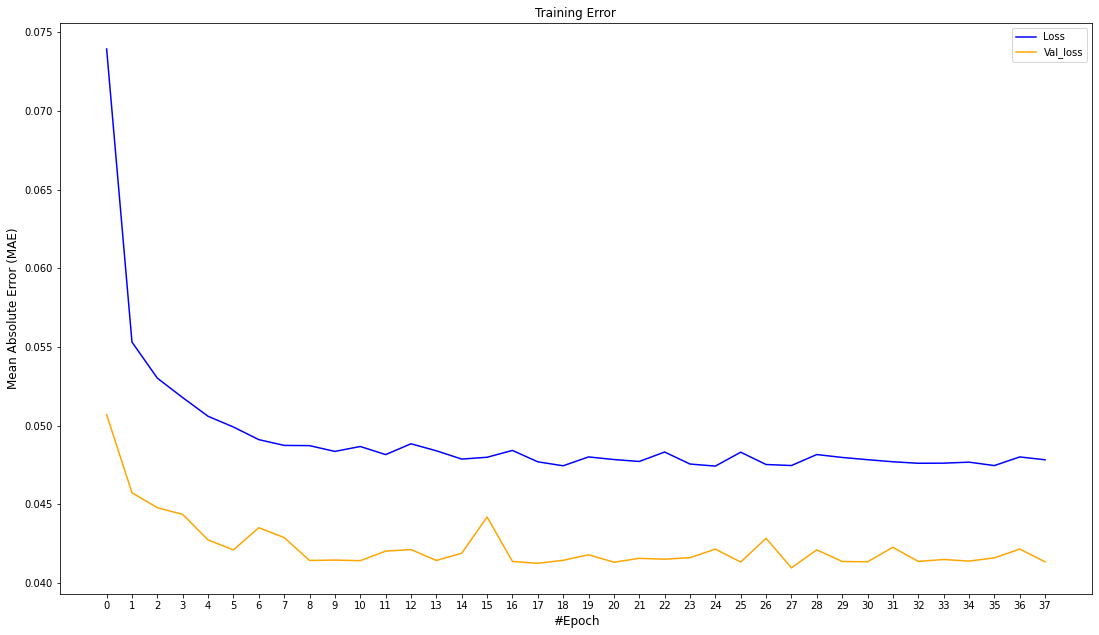

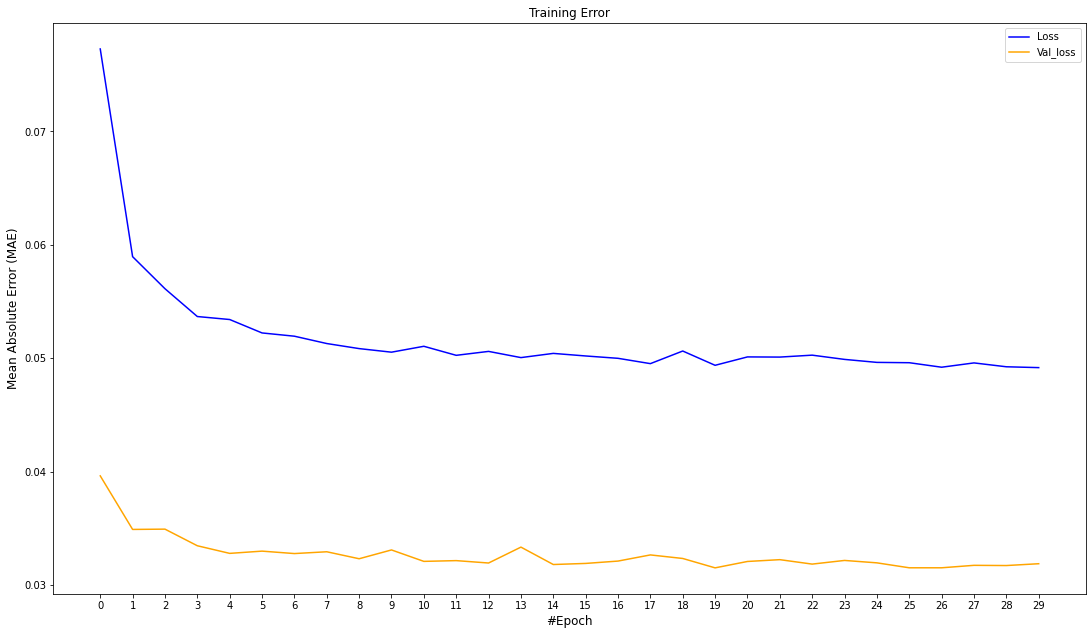

In [ ]:
plot_loss_and_val_loss(hist_of_BTC_with_best_model)
plot_loss_and_val_loss(hist_of_BTC_ETH_with_best_model)

<p> It worths to mention, that even if the losses of the training set are almost the same, the dataset with the two coins exhibits a better performance in terms of validation loss.</p>

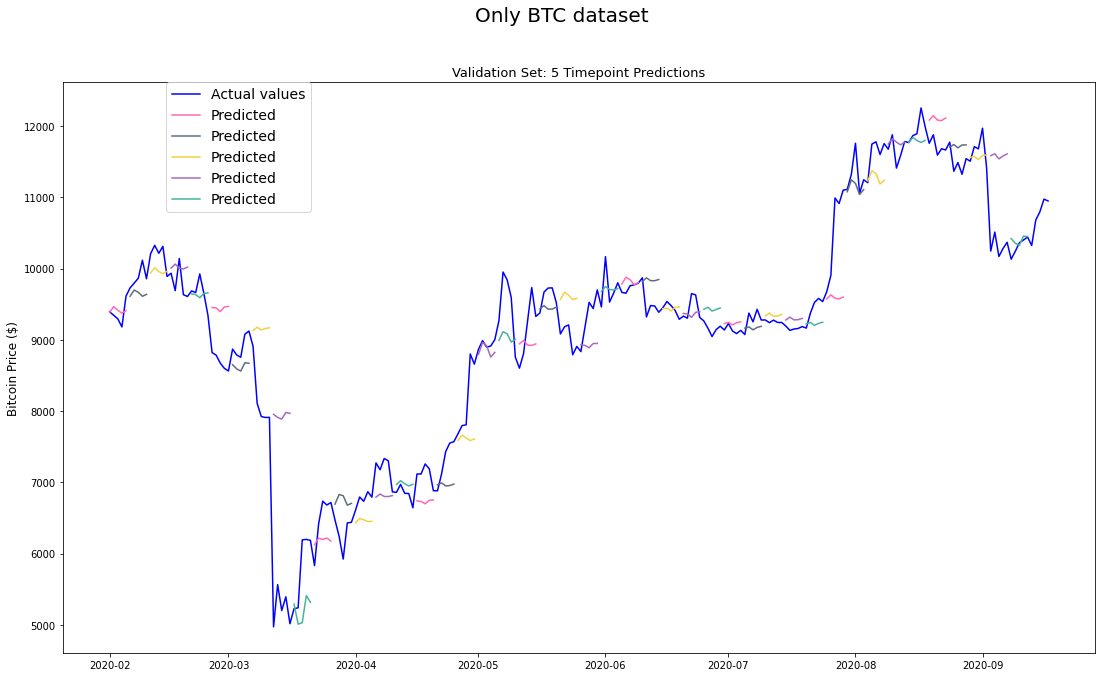

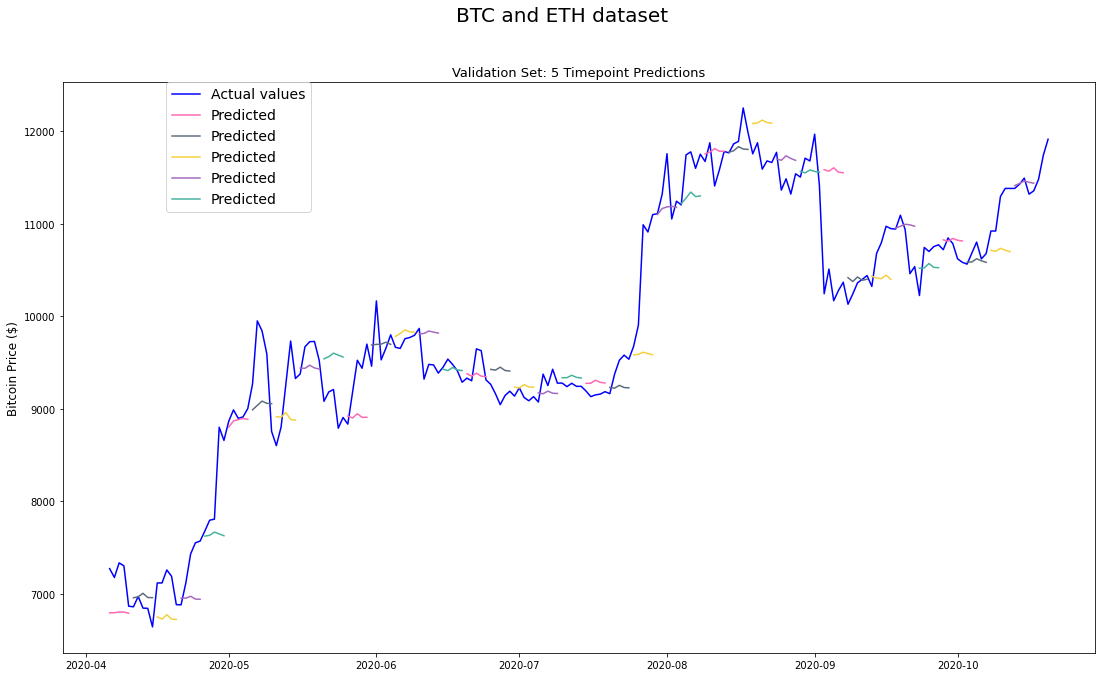

In [ ]:
plot_actual_against_ranged_prediction(btc_dataset_with_3_features, best_model_BTC, pred_range, window_len, LSTM_validation_inputs_BTC, validation_set_original_BTC, split_date_BTC, split_date_val_BTC, 'BTC_Close', 'Only BTC dataset')
print('\n\n')
plot_actual_against_ranged_prediction(btc_eth_dataset_with_3_features, best_model_BTC_ETH, pred_range, window_len, LSTM_validation_inputs_BTC_ETH, validation_set_original_BTC_ETH, split_date_BTC_ETH, split_date_val_BTC_ETH, 'BTC_Close', 'BTC and ETH dataset')

<p> As you may see, the validation sets differ. That's because during the creation of the dataset with the two coins, the merge is being done over the Date field and because of the Ethereum exists less than the Bitcoin, we end up with a smaller dataset. Then because we keep the same percentage for the validation sets these two date ranges, end up not to be the same. </p>
<p>Unfortunatelly even if the MAE decreases in the second case, the results does not seem better (or we do not have a way to intrepret the reason this happens and how to explain it). </p>
<p> Also, it worths to be mention that during this phase, we tried also with different loss functions like Mean Square Error and different optimizers like RMSProp, etc. </p>

<h1>Section 4<h1>
<h2> Extend dataset with social media information</h2>
<p> As we already mentioned earlier, we will continure our experiments by extending the datasets to contain also social media feed. We used the cryptocompare's api free version. The dataset we constructed can be found in this <a href='https://github.com/teoad95/Deep-learning-Cryptocurrency-price-prediction/blob/main/Datasets/Social%20media/Bitcoin_social_media_info.csv'>link</a>.</p>
<p>Starting, we will combine the social media and market info datasets into one.</p>

In [11]:
btc_social_media_url = 'https://raw.githubusercontent.com/teoad95/Deep-learning-Cryptocurrency-price-prediction/main/Datasets/Social%20media/Bitcoin_social_media_info.csv'
eth_social_media_url = 'https://raw.githubusercontent.com/teoad95/Deep-learning-Cryptocurrency-price-prediction/main/Datasets/Social%20media/Ethereum_social_media_info.csv'

<p> We will define a function for the dataset creation </p>

In [18]:
def dataset_creation_with_social(crypto_list):
    datasets = {} #Store all datasets with market information here
    social_datasets = {} #Store all datasets with social media information here
    datasets_list = {'BTC' : [btc_url, btc_social_media_url], 'ETH' : [eth_url, eth_social_media_url]}
    
    min_dates = {} #Store all minimum dates here
    max_dates = {} #Store all maximum dates here
    
    #Get market information for each coin from the corresponding csv
    for dataset_name, urls in datasets_list.items():
        if (dataset_name) in crypto_list:
            datasets[dataset_name] = pd.read_csv(urls[0]) 

            datasets[dataset_name]['Date'] = pd.to_datetime(datasets[dataset_name]['Date'])
            datasets[dataset_name].fillna(method='ffill', inplace=True)

            #Create new columns 'close_off_high' and 'volatility' in order to make predictions more accurate:
            kwards = {'close_off_high': lambda x: 2 * (x['High'] - x['Close']) / (x['High'] - x['Low']) - 1,
              'volatility': lambda x: (x['High'] - x['Low']) / (x['Open'])
              }

            datasets[dataset_name] = datasets[dataset_name].assign(**kwards)
            
            datasets[dataset_name].fillna(-1, inplace=True) #Fill possible NaN close_off_high values with -1
                                                            #Because NaN values caused by (0/0)-1
            

            first_date = pd.to_datetime(datasets[dataset_name]['Date'][0])
            min_dates[dataset_name]=first_date
            
            last_date = pd.to_datetime(datasets[dataset_name]['Date'].iloc[-1])
            max_dates[dataset_name] = last_date
    
    
    #Get social media information for each coin from the corresponding csv
    for dataset_name, urls in datasets_list.items():
        if (dataset_name) in crypto_list:
          
            social_datasets[dataset_name] = pd.read_csv(urls[1]) 
            
            social_datasets[dataset_name]['time'] = pd.to_datetime(social_datasets[dataset_name]['time'])
            
            #Drop first column which is an unused index
            social_datasets[dataset_name] = social_datasets[dataset_name].iloc[:, 1:]
            
            #We observed that there are many zero rows at social media datasets.
            #We should find the first row which is non-zero
            res = [next(((j, i) for i, j in enumerate(social_datasets[dataset_name][col]) if j != 0), (0, 0)) 
                   for col in social_datasets[dataset_name] if col != 'time']
            
            #Get all columns except 'time'
            columns_except_time = [col for col in social_datasets[dataset_name].columns if col != 'time']
            
            #Store the index of each column with the first non-zero element
            df_res = pd.DataFrame(res, columns=['value', 'position'], index=columns_except_time)
            
            #Get the minimum of these indices
            first_non_zero_row = df_res['position'].min()

            
            first_date = pd.to_datetime(social_datasets[dataset_name]['time'][first_non_zero_row])
            if first_date >  min_dates[dataset_name]:
                 min_dates[dataset_name] = first_date
                    
            last_date = pd.to_datetime(social_datasets[dataset_name]['time'].iloc[-1])
            if last_date < max_dates[dataset_name]:
                max_dates[dataset_name] = last_date
            

    max_date = max(min_dates.values(), key=lambda v: v)
    min_date = min(max_dates.values(), key=lambda v: v)
    

    #Drop all the data which are prior to max_date and later to min_date
    for dataset in datasets:
        datasets[dataset] = datasets[dataset][(datasets[dataset]['Date'] >= max_date) & 
                                              (datasets[dataset]['Date'] <= min_date)]
        
    for dataset in social_datasets:
        social_datasets[dataset] = social_datasets[dataset][(social_datasets[dataset]['time'] >= max_date) & 
                                                            (social_datasets[dataset]['time'] <= min_date)]

    
    #Compute the average and standard deviation of 'Close' value for the last 7-days and 30-days(month): 
    for dataset in datasets:

        temp = datasets[dataset].copy()

        #Drop the first 30 days to be able to compute average and standard deviation of month for the rows of the table
        temp = temp[29:]

        temp['mean_7days_Close'] = datasets[dataset]['Close'].rolling(window=7).mean()

        temp['mean_month_Close'] = datasets[dataset]['Close'].rolling(window=30).mean()

        temp['std_7days_Close'] = datasets[dataset]['Close'].rolling(window=7).std()

        temp['std_month_Close'] = datasets[dataset]['Close'].rolling(window=30).std()

        datasets[dataset] = temp.copy()
        
    
    #Drop the first 30 days of 'social_datasets' to be aligned with 'datasets'
    for dataset in social_datasets:
            social_datasets[dataset] = social_datasets[dataset][29:]
        
        



    #Rename the columns
    count = 0
    for dataset in datasets:

        datasets[dataset] = datasets[dataset].rename(columns={'Close':dataset+'_Close', 'Open':dataset+'_Open', 
                                                              'High':dataset+'_High', 'Low':dataset+'_Low', 
                                                              'Adj Close':dataset+'_Adj_Close', 
                                                              'Volume':dataset+'_Volume', 
                                                              'close_off_high':dataset+'_close_off_high',
                                                              'volatility':dataset+'_volatility',
                                                              'mean_7days_Close':dataset+'_mean_7days_Close',
                                                              'mean_month_Close':dataset+'_mean_month_Close',
                                                              'std_7days_Close':dataset+'_std_7days_Close',
                                                              'std_month_Close':dataset+'_std_month_Close'})
        
        
        if count == 0:
            
            date_col = (datasets[dataset]['Date'].reset_index()).drop(['index'], axis=1)
            
            
        datasets[dataset] = ((datasets[dataset].drop(['Date'], axis=1)).reset_index()).drop(['index'], axis=1) 
        
    
    
    for dataset in social_datasets:
        
        social_datasets[dataset] = social_datasets[dataset].rename(columns=lambda x: dataset+'_'+x)
        
        social_datasets[dataset] = ((social_datasets[dataset].drop([dataset+'_time'], axis=1)).reset_index()).drop(['index'], 
                                                                                                          axis=1) 
                                                            
    
    
    #Concatenate all datasets to one 
    whole_market_dataset = pd.concat([datasets[dataset] for dataset in datasets], axis=1)
    whole_social_dataset = pd.concat([social_datasets[dataset] for dataset in social_datasets], axis=1)
    whole_dataset = pd.concat([date_col, whole_market_dataset, whole_social_dataset], axis=1)
    
   
    return whole_dataset

<p> By using the function we created 2 new datasets, one with BTC market info and social media feed, and one with BTC and ETH market info and social media feed. </p>

In [16]:
btc_sm_and_mi_combined_ds = dataset_creation_with_social(['BTC'])
btc_and_eth_sm_and_mi_combined_ds = dataset_creation_with_social(['BTC', 'ETH'])

In [37]:
feature_list = list(map(lambda x: x.replace("BTC_", ""), btc_sm_and_mi_combined_ds.columns[1:].to_list()))

In [60]:
LSTM_ranged_training_outputs, LSTM_ranged_validation_outputs, LSTM_training_inputs, LSTM_validation_inputs, LSTM_test_inputs, split_date, split_date_val, validation_set_original = get_specific_features_normalized(btc_sm_and_mi_combined_ds, feature_list)
model = build_model_with_best_architecture(LSTM_training_inputs)
hist_of_BTC_with_social_media_included = model.fit(LSTM_training_inputs[:-pred_range], LSTM_ranged_training_outputs, validation_data=(LSTM_validation_inputs[:-pred_range], LSTM_ranged_validation_outputs), epochs=100, batch_size=64, verbose=0, shuffle=True, workers=8, callbacks=[early_stopping])

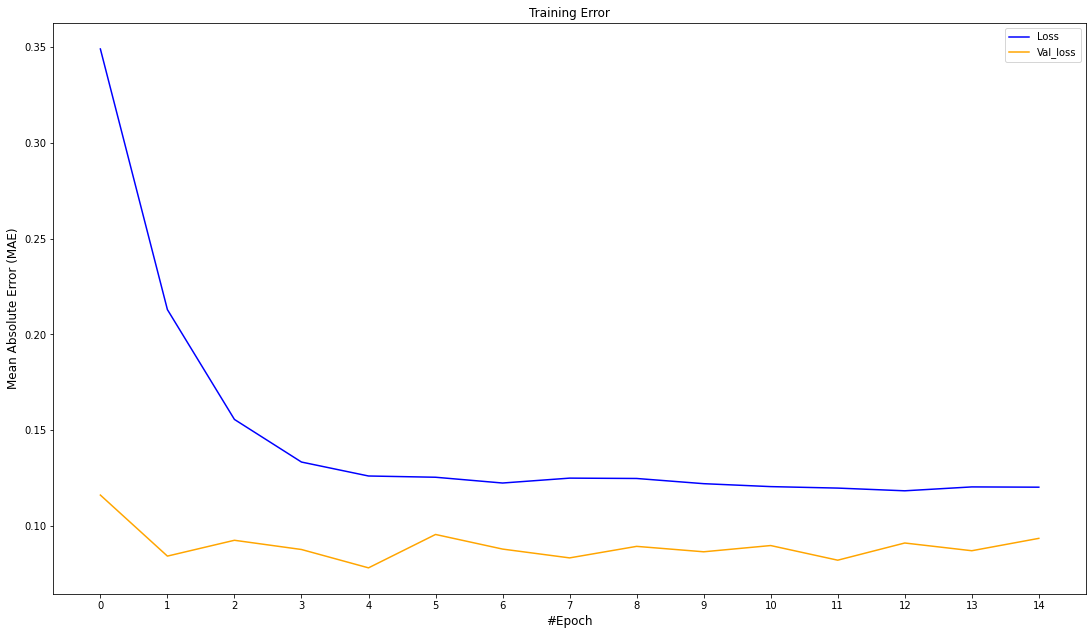

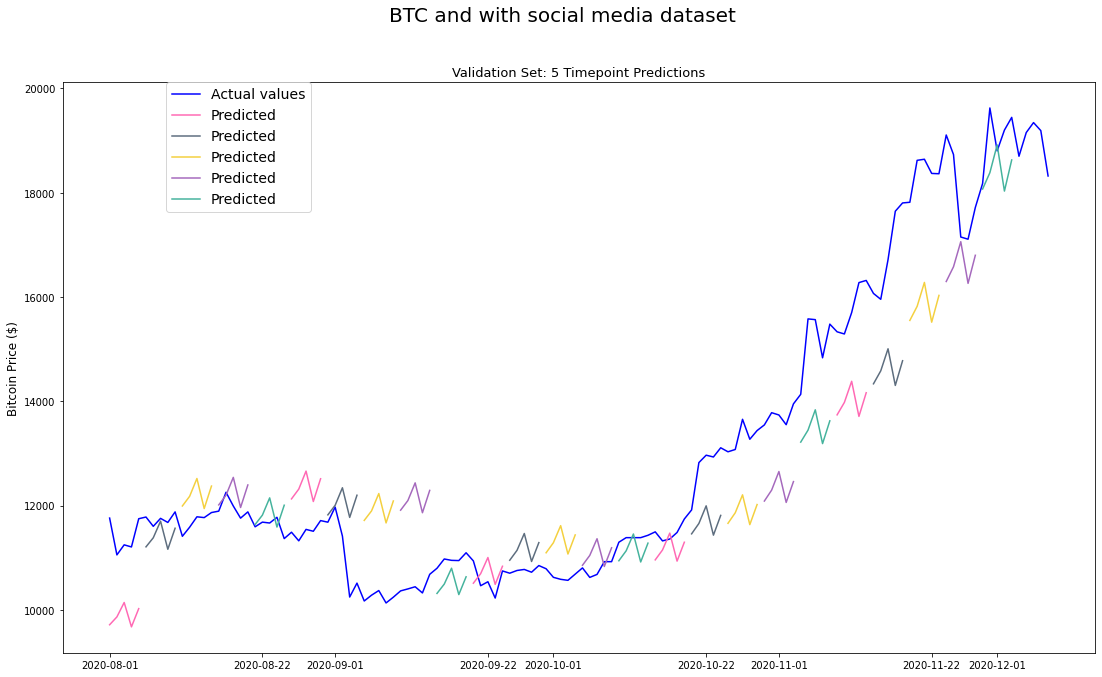

In [64]:
plot_loss_and_val_loss(hist_of_BTC_with_social_media_included)
plot_actual_against_ranged_prediction(btc_sm_and_mi_combined_ds, model, pred_range, window_len, LSTM_validation_inputs, validation_set_original, split_date, split_date_val, 'BTC_Close', 'BTC and with social media dataset')

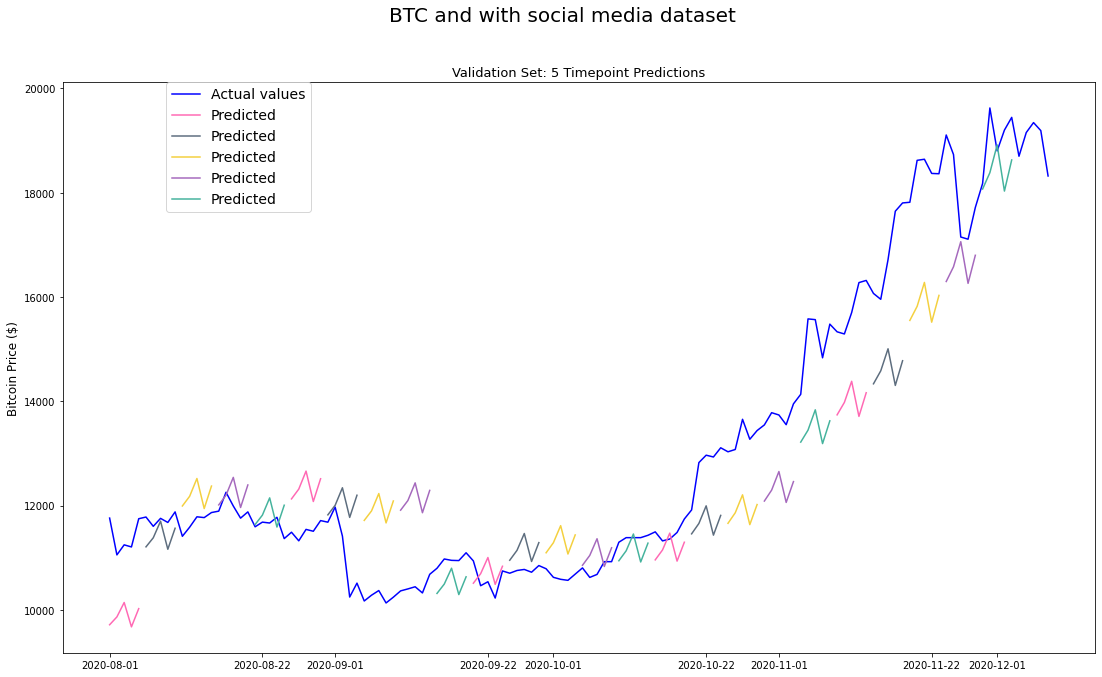

In [63]:
plot_actual_against_ranged_prediction(btc_sm_and_mi_combined_ds, model, pred_range, window_len, LSTM_validation_inputs, validation_set_original, split_date, split_date_val, 'BTC_Close', 'BTC and with social media dataset')